## Import the BNN Package

In [13]:
import bnn

## To check available parameters

In [14]:
print(bnn.available_params(bnn.NETWORK_CNVW1A1))

['road-signs', 'streetview', 'cifar10']


## Initiate the classifier

In [15]:
hw_classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW1A1,'cifar10',bnn.RUNTIME_HW)
sw_classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW1A1,'cifar10',bnn.RUNTIME_SW)

## list the classifier

In [16]:
print(hw_classifier.classes)

['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


## open image to be  classified

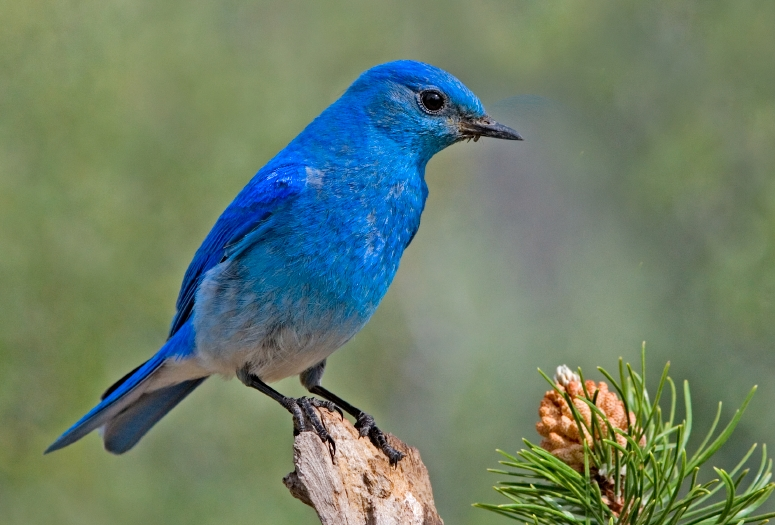

In [17]:
from PIL import Image
import numpy as np

im = Image.open('/home/xilinx/jupyter_notebooks/bnn/pictures/bird.jpg')
im 

## Launching the BNN in hardware

In [18]:
class_out=hw_classifier.classify_image(im)
print("Class number: {0}".format(class_out))
print("Class name: {0}".format(hw_classifier.class_name(class_out)))

Inference took 1586.00 microseconds
Classification rate: 630.52 images per second
Class number: 2
Class name: Bird


## launching the BNN in Software

In [19]:
class_out = sw_classifier.classify_image(im)
print("Class number: {0}".format(class_out))
print("Class name: {0}".format(sw_classifier.class_name(class_out)))

Inference took 1643748.00 microseconds
Classification rate: 0.61 images per second
Class number: 2
Class name: Bird


## classified information in detail

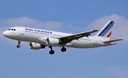

Inference took 1582.00 microseconds
Classification rate: 632.11 images per second
   [CLASS]    [RANKING]
  Airplane       375
Automobile       284
      Bird       282
       Cat       276
      Deer       278
       Dog       127
      Frog       132
     Horse       265
      Ship       262
     Truck       269


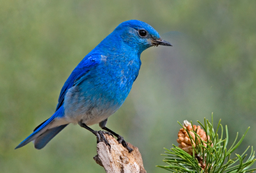

Inference took 1583.00 microseconds
Classification rate: 631.71 images per second
   [CLASS]    [RANKING]
  Airplane       258
Automobile       183
      Bird       399
       Cat       273
      Deer       279
       Dog       256
      Frog       261
     Horse       258
      Ship       263
     Truck       162


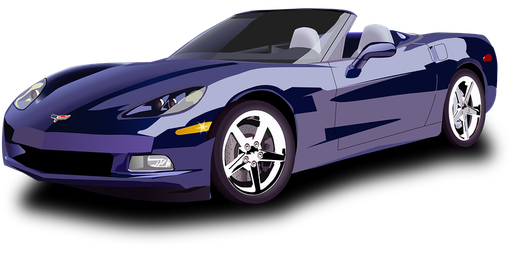

Inference took 1582.00 microseconds
Classification rate: 632.11 images per second
   [CLASS]    [RANKING]
  Airplane       316
Automobile       323
      Bird       223
       Cat       213
      Deer       211
       Dog       204
      Frog       207
     Horse       246
      Ship       241
     Truck       234


In [20]:
from IPython.display import display

im = Image.open('/home/xilinx/jupyter_notebooks/bnn/pictures/airplane.jpg')
im.thumbnail((128, 128), Image.ANTIALIAS)
display(im) 
air_class = hw_classifier.classify_image_details(im)
print("{: >10}{: >13}".format("[CLASS]","[RANKING]"))
for i in range(len(air_class)):
    print("{: >10}{: >10}".format(hw_classifier.classes[i],air_class[i]))

im = Image.open('/home/xilinx/jupyter_notebooks/bnn/pictures/bird.jpg')
im.thumbnail((256, 256), Image.ANTIALIAS)
display(im) 
bird_class = hw_classifier.classify_image_details(im)
print("{: >10}{: >13}".format("[CLASS]","[RANKING]"))
for i in range(len(bird_class)):
    print("{: >10}{: >10}".format(hw_classifier.classes[i],bird_class[i]))

im = Image.open('/home/xilinx/jupyter_notebooks/bnn/pictures/car.png')
im.thumbnail((512, 512), Image.ANTIALIAS)
display(im) 
car_class = hw_classifier.classify_image_details(im)
print("{: >10}{: >13}".format("[CLASS]","[RANKING]"))
for i in range(len(car_class)):
    print("{: >10}{: >10}".format(hw_classifier.classes[i],car_class[i]))



The numbers can be difficult to visualise so we can use matplotlib to graph the output. Numbers are shown in units of 100

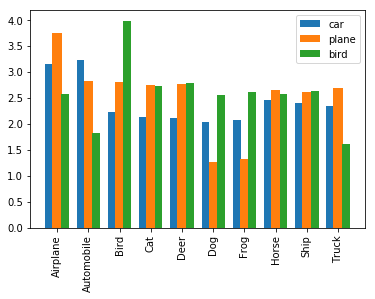

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

x_pos = np.arange(len(car_class))
fig, ax = plt.subplots()
ax.bar(x_pos - 0.25, (car_class/100.0), 0.25)
ax.bar(x_pos, (air_class/100.0), 0.3)
ax.bar(x_pos + 0.25, (bird_class/100.0), 0.25)
ax.set_xticklabels(hw_classifier.classes, rotation='vertical')
ax.set_xticks(x_pos)
ax.set
plt.legend(["car","plane","bird"])
plt.show()

### classify Multiple Images

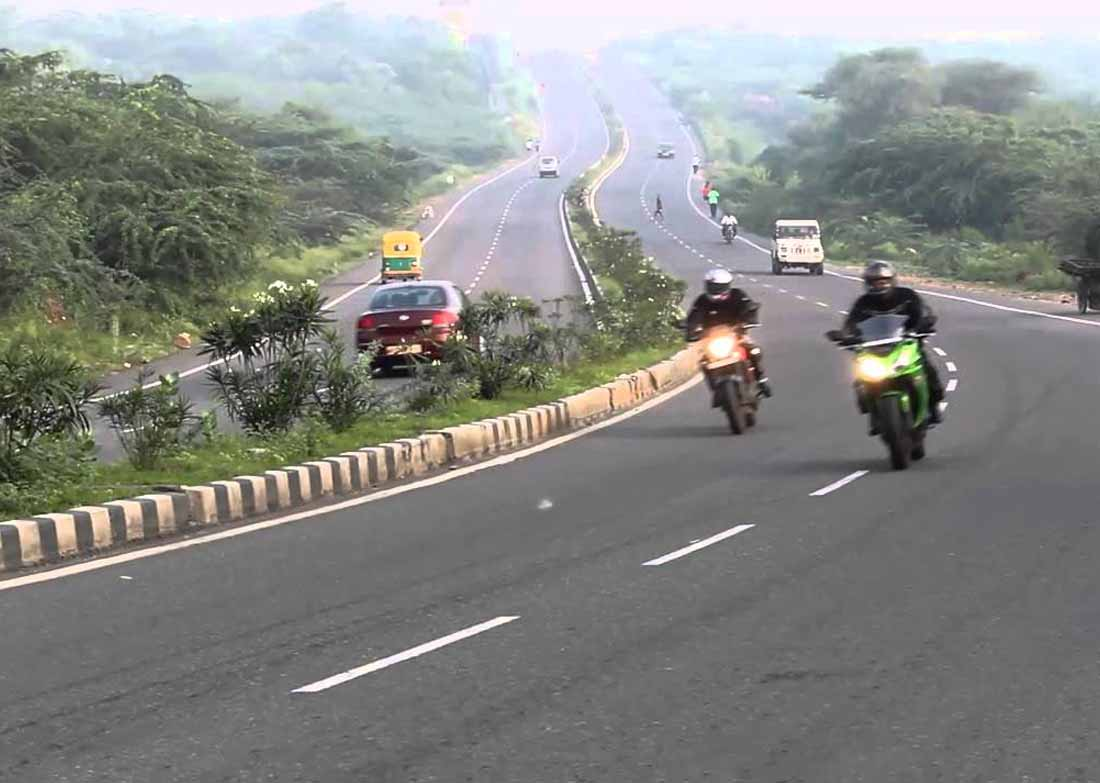

In [22]:
im = Image.open('/home/xilinx/jupyter_notebooks/bnn/pictures/highway.jpg')
im

First task is to create a set of image tiles from large image to search. Different scales allow the network to check for different sized cars.

In [23]:
images = []
bounds = []
for s in [32, 64]:
    stride =  s // 2
    x_tiles = im.width // stride
    y_tiles = im.height // stride
    
    for j in range(y_tiles):
        for i in range(x_tiles):
            bound = (stride * i, stride * j, stride * i + s, stride * j + s)
            if bound[2] <= im.width and bound[3] < im.height:
                c = im.crop(bound)
                images.append(c)
                bounds.append(bound)

print(len(images))

3908


Next the set of images are passed through the classifier. Note how the rate of images is 3 times greater than for single image classification. Once the classes are returned, numpy can quickly find all of the indicies of tiles which have matched as cars.


results = hw_classifier.classify_images(images)

In [24]:
results = hw_classifier.classify_images(images)
cars = results == 1
indicies = cars.nonzero()[0]

Inference took 1282486.03 microseconds, 328.17 usec per image
Classification rate: 3047.21 images per second


To visualise the output we can draw the bounds of each matched rectangle on the original image.

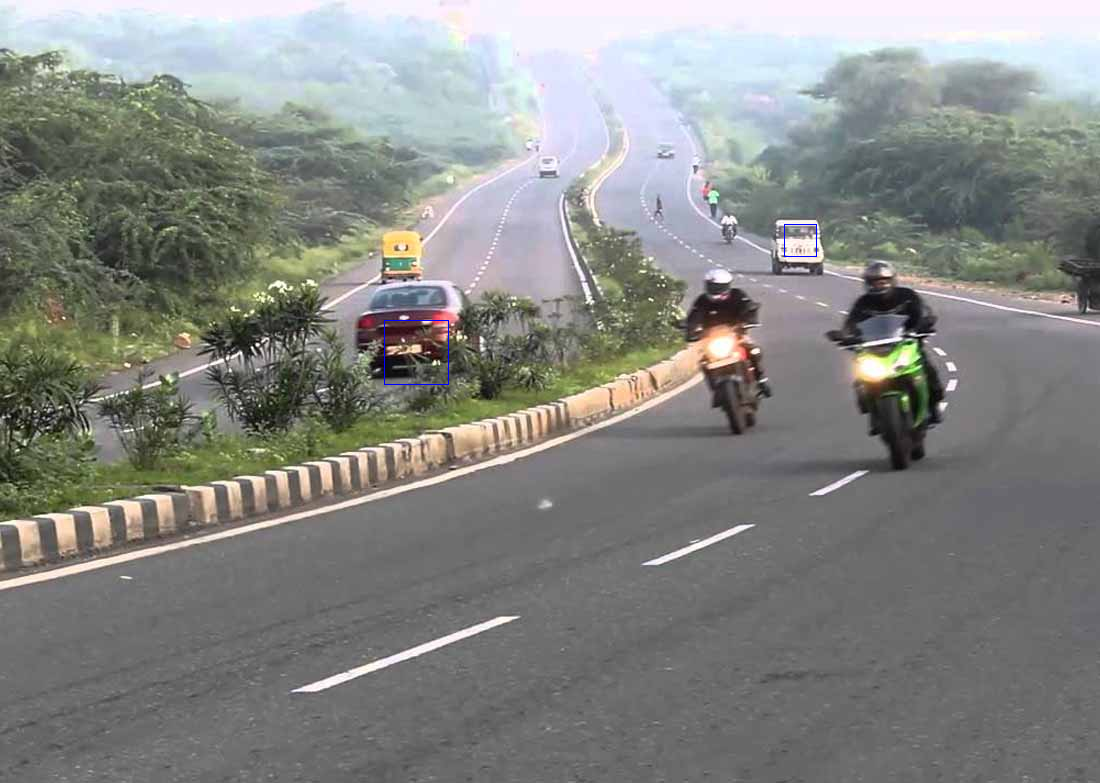

In [26]:
from PIL import ImageDraw

draw = ImageDraw.Draw(im)
for i in indicies:
    draw.rectangle(bounds[i], outline='blue')

im

## Now reset5 the device

In [31]:
from pynq import Xlnk

xlnk = Xlnk()
xlnk.xlnk_reset()